In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom
from lsst.afw import image as afwImage

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

In [ ]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)


In [7]:
# at the moment comcam only in Cassandra
# from lsst.analysis.ap import apdbCassandra
# or4_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcamsim_or4.py')
# comcam_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcam.py')

In [8]:
# Load collection
repo = "embargo_new"
collection = "LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841"
instrument = "LSSTComCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [9]:
bands = ["u", "g", "r", "i", "z", "y"]

verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_differenceExp", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 247 differenceExps for band 'u'
Found 774 differenceExps for band 'g'
Found 2662 differenceExps for band 'r'
Found 1777 differenceExps for band 'i'
Found 765 differenceExps for band 'z'
Found 584 differenceExps for band 'y'


In [12]:
i = 50
data_id = datasetRefs_dia[i].dataId
print(data_id)

{instrument: 'LSSTComCam', detector: 0, visit: 2024112000314, band: 'y', day_obs: 20241120, physical_filter: 'y_04'}


In [39]:
# coord = lsst.geom.SpherePoint(targetCoord.ra.deg, targetCoord.dec.deg, units=lsst.geom.degrees)
# tract_info = skymap.findTract(coord)

In [61]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")
print(len(lc_refs))
print(len(obj_refs))

43
43


Text(0, 0.5, 'Number of diaObjects')

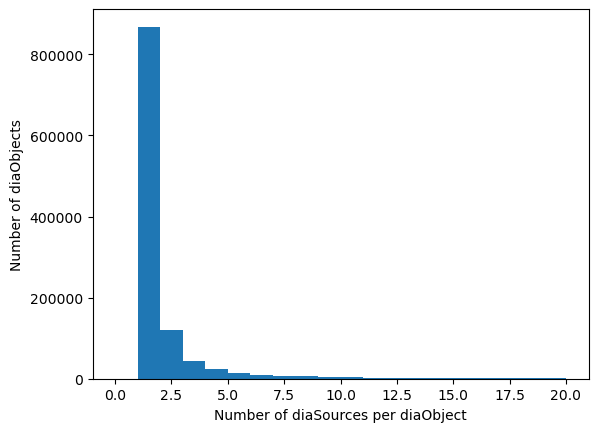

In [142]:
# List of tract indices to process
tract_indices = np.arange(0, 43)

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    dia_Obj = butler.get(obj_ref)  # Fetch diaObj for this tract
    diaSource = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(dia_Obj)
    diaSource_list.append(diaSource)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

dia_Obj = combined_dia_Obj
diaSource = combined_diaSource

plt.hist(combined_dia_Obj['nDiaSources'], bins=20, range=(0, 20));
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Number of diaObjects')

In [135]:
dia_Obj['nDiaSources'].describe()

count    1.117275e+06
mean     1.808617e+00
std      3.540546e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.630000e+02
Name: nDiaSources, dtype: float64

In [223]:
len(np.unique(diaSource['visit']))

772

In [225]:
len(np.unique(diaSource['diaObjectId']))

1117275

In [ ]:
len(diaSource)

2020723

In [230]:
output_string = (
    f"Number of unique visits: {len(np.unique(diaSource['visit']))}, "
    f"Number of unique diaObjectId: {len(np.unique(diaSource['diaObjectId']))}, "
    f"Total number of diaSource entries: {len(diaSource)}"
)

print(output_string)

Number of unique visits: 772, Number of unique diaObjectId: 1117275, Total number of diaSource entries: 2020723


In [136]:
lc = diaSource[diaSource['diaObjectId'] == dia_Obj_many_Src.index[0]]
lc;

In [137]:
"""
dia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)
template = butler.get("goodSeeingDiff_templateExp", dataId=data_id)
calexp = butler.get("calexp", dataId=data_id)
src = butler.get("src", dataId=data_id)
dia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)
dia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) 
"""

'\ndia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)\ntemplate = butler.get("goodSeeingDiff_templateExp", dataId=data_id)\ncalexp = butler.get("calexp", dataId=data_id)\nsrc = butler.get("src", dataId=data_id)\ndia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)\ndia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) \n'

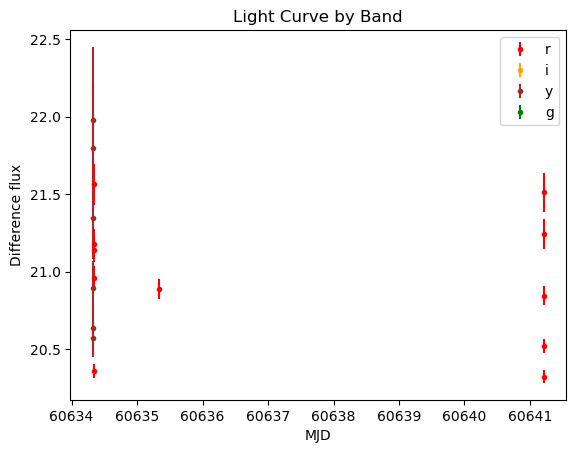

In [138]:
import matplotlib.pyplot as plt

# Define LSST band colors
band_colors = {
    "u": "purple",
    "g": "green",
    "r": "red",
    "i": "orange",
    "z": "darkgray",
    "y": "brown"
}

# Create the figure
fig = plt.figure()

# Plot the data for each band
for band in set(lc['band']):
    lcb = lc.query(f'band == "{band}"')
    # Convert flux and flux error to magnitudes
    mag, magErr = create_mag_errors(lcb['psfFlux'], lcb['psfFluxErr'])
    
    # Plot magnitudes with errors
    plt.errorbar(
        lcb['midpointMjdTai'], 
        mag, 
        magErr, 
        label=band, 
        linestyle='none', 
        fmt='.', 
        color=band_colors.get(band, 'black')  # Use black as default for unknown bands
    )

# Add legend, labels, and display
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Difference flux')
plt.title('Light Curve by Band')
plt.show()

In [99]:
mag, magErr = create_mag_errors(diaSource['scienceFlux'], diaSource['scienceFluxErr'])

In [139]:
print(diaSource['band'].unique())

['i' 'g' 'r' 'y' 'z' 'u']


In [146]:
from tqdm import tqdm

In [176]:
# Step 1: Calculate mean flux and mean SNR for each diaObjectId in each band
mean_flux_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['scienceFlux'].mean().unstack(fill_value=0)
mean_snr_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['snr'].mean().unstack(fill_value=-99)

# Rename columns dynamically for all bands
band_flux_columns = {band: f"{band}_band_flux_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
band_snr_columns = {band: f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
mean_flux_per_object_band = mean_flux_per_object_band.rename(columns=band_flux_columns).reset_index()
mean_snr_per_object_band = mean_snr_per_object_band.rename(columns=band_snr_columns).reset_index()

# Step 2: Merge mean flux and SNR values into dia_Obj_field
dia_Obj_field_updated = dia_Obj.merge(mean_flux_per_object_band, on='diaObjectId', how='left')
dia_Obj_field_updated = dia_Obj_field_updated.merge(mean_snr_per_object_band, on='diaObjectId', how='left')

# Step 3: Calculate magnitudes for all bands
for band in tqdm(['i', 'g', 'r', 'y', 'z', 'u']):
    flux_col = f"{band}_band_flux_mean"
    mag_col = f"{band}_band_mag"
    dia_Obj_field_updated[mag_col] = dia_Obj_field_updated[flux_col].apply(create_mag)

# Replace infinite values with NaN
dia_Obj_field_updated.replace([np.inf, -99, -np.inf], np.nan, inplace=True)

# Select and display the magnitude columns, SNR, and diaObjectId
output_columns = ['diaObjectId'] + \
                 [f"{band}_band_mag" for band in ['i', 'g', 'r', 'y', 'z', 'u']] + \
                 [f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']]

result = dia_Obj_field_updated[output_columns]

# Display the resulting DataFrame
result 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:08<00:00, 51.48s/it]


,diaObjectId,i_band_mag,g_band_mag,r_band_mag,y_band_mag,z_band_mag,u_band_mag,i_band_snr_mean,g_band_snr_mean,r_band_snr_mean,y_band_snr_mean,z_band_snr_mean,u_band_snr_mean
0,983398801836343297,24.369768,NaN,NaN,NaN,NaN,NaN,5.325526,NaN,NaN,NaN,NaN,NaN
1,983398801836343298,19.945555,NaN,NaN,NaN,NaN,NaN,15.802820,NaN,NaN,NaN,NaN,NaN
2,983398801836343299,18.555489,NaN,NaN,NaN,NaN,NaN,6.246613,NaN,NaN,NaN,NaN,NaN
3,983398801836343300,21.625804,NaN,NaN,NaN,NaN,NaN,8.079609,NaN,NaN,NaN,NaN,NaN
4,983398801836343301,19.830976,NaN,NaN,NaN,NaN,NaN,6.906067,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117270,1766668895231410233,NaN,NaN,17.949047,NaN,NaN,NaN,NaN,NaN,11.118386,NaN,NaN,NaN
1117271,1766668895231410234,NaN,NaN,18.592064,NaN,NaN,NaN,NaN,NaN,5.006464,NaN,NaN,NaN
1117272,1766668895231410235,NaN,NaN,23.149542,NaN,NaN,NaN,NaN,NaN,5.119714,NaN,NaN,NaN
1117273,1766668895231410236,NaN,NaN,19.183325,NaN,NaN,NaN,NaN,NaN,7.049816,NaN,NaN,NaN


In [175]:
mean_snr_per_object_band

band,diaObjectId,g_band_snr_mean,i_band_snr_mean,r_band_snr_mean,u_band_snr_mean,y_band_snr_mean,z_band_snr_mean
0,199279885464633345,0.0,8.428125,0.0,0.0,0.0,0.0
1,199279885464633346,0.0,8.552146,0.0,0.0,0.0,0.0
2,199279885464633347,0.0,5.619455,0.0,0.0,0.0,0.0
3,199279885464633348,0.0,7.705184,0.0,0.0,0.0,0.0
4,199279885464633349,0.0,7.398534,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1117270,4708236333485654039,0.0,7.387986,0.0,0.0,0.0,0.0
1117271,4708236333485654040,0.0,14.507456,0.0,0.0,0.0,0.0
1117272,4708236333485654041,0.0,7.995700,0.0,0.0,0.0,0.0
1117273,4708236333485654042,0.0,5.170148,0.0,0.0,0.0,0.0


In [163]:
result

,diaObjectId,i_band_mag,g_band_mag,r_band_mag,y_band_mag,z_band_mag,u_band_mag,i_band_snr_mean,g_band_snr_mean,r_band_snr_mean,y_band_snr_mean,z_band_snr_mean,u_band_snr_mean
0,983398801836343297,24.369768,NaN,NaN,NaN,NaN,NaN,5.325526,0.0,0.000000,0.0,0.0,0.0
1,983398801836343298,19.945555,NaN,NaN,NaN,NaN,NaN,15.802820,0.0,0.000000,0.0,0.0,0.0
2,983398801836343299,18.555489,NaN,NaN,NaN,NaN,NaN,6.246613,0.0,0.000000,0.0,0.0,0.0
3,983398801836343300,21.625804,NaN,NaN,NaN,NaN,NaN,8.079609,0.0,0.000000,0.0,0.0,0.0
4,983398801836343301,19.830976,NaN,NaN,NaN,NaN,NaN,6.906067,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117270,1766668895231410233,NaN,NaN,17.949047,NaN,NaN,NaN,0.000000,0.0,11.118386,0.0,0.0,0.0
1117271,1766668895231410234,NaN,NaN,18.592064,NaN,NaN,NaN,0.000000,0.0,5.006464,0.0,0.0,0.0
1117272,1766668895231410235,NaN,NaN,23.149542,NaN,NaN,NaN,0.000000,0.0,5.119714,0.0,0.0,0.0
1117273,1766668895231410236,NaN,NaN,19.183325,NaN,NaN,NaN,0.000000,0.0,7.049816,0.0,0.0,0.0


In [164]:
result.to_parquet('result.parquet', index=False)

print("DataFrame saved as 'result.parquet'.")

DataFrame saved as 'result.parquet'.


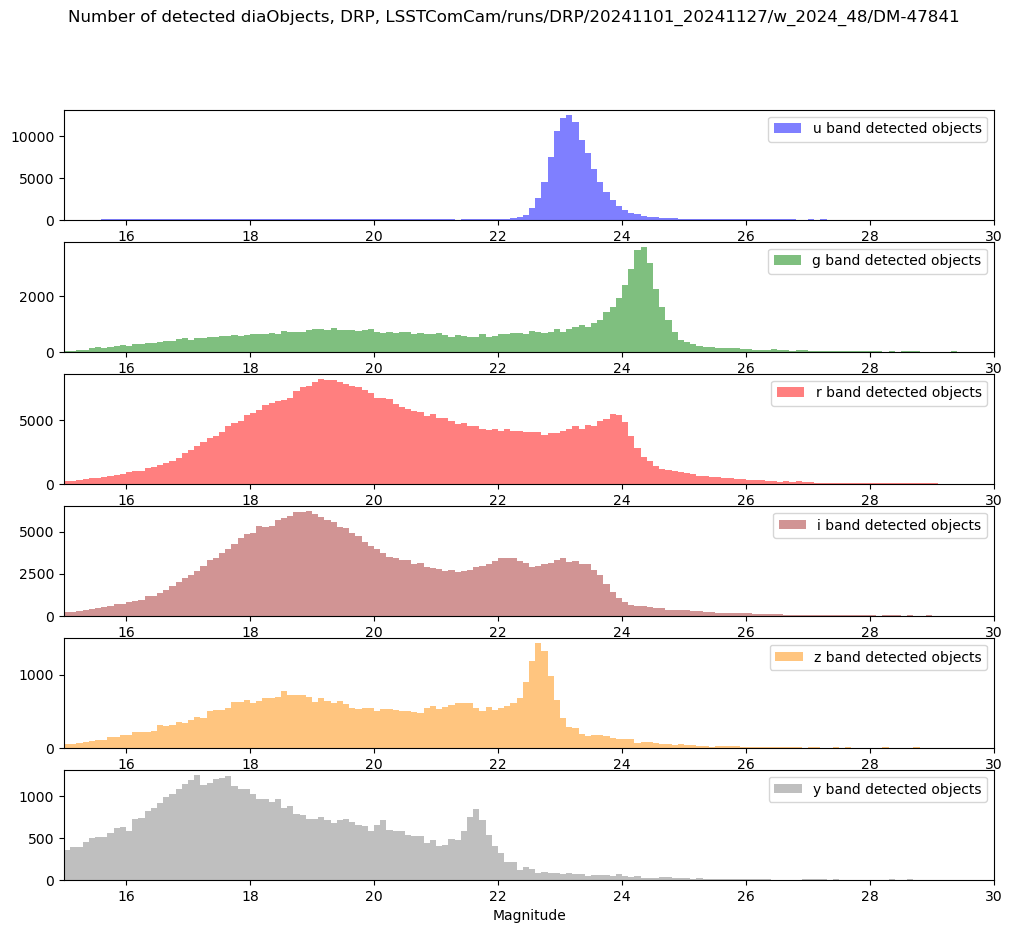

In [158]:
plt.figure(figsize=(12, 10))
plt.suptitle('Number of detected diaObjects, DRP, LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841')

plt.subplot(6, 1, 1)
plt.hist(result['u_band_mag'][~np.isnan(result['u_band_mag'])], color='blue', alpha=0.5, bins=np.arange(15,30,0.1), label='u band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1, 2)
plt.hist(result['g_band_mag'][~np.isnan(result['g_band_mag'])], color='g', alpha=0.5, bins=np.arange(15,30,0.1), label='g band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1, 3)
plt.hist(result['r_band_mag'][~np.isnan(result['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,4)
plt.hist(result['i_band_mag'][~np.isnan(result['i_band_mag'])], color='brown', alpha=0.5, bins=np.arange(15,30,0.1), label='i band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,5)
plt.hist(result['z_band_mag'][~np.isnan(result['z_band_mag'])], color='darkorange', alpha=0.5, bins=np.arange(15,30,0.1), label='z band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,6)
plt.hist(result['y_band_mag'][~np.isnan(result['y_band_mag'])], color='gray', alpha=0.5, bins=np.arange(15,30,0.1), label='y band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

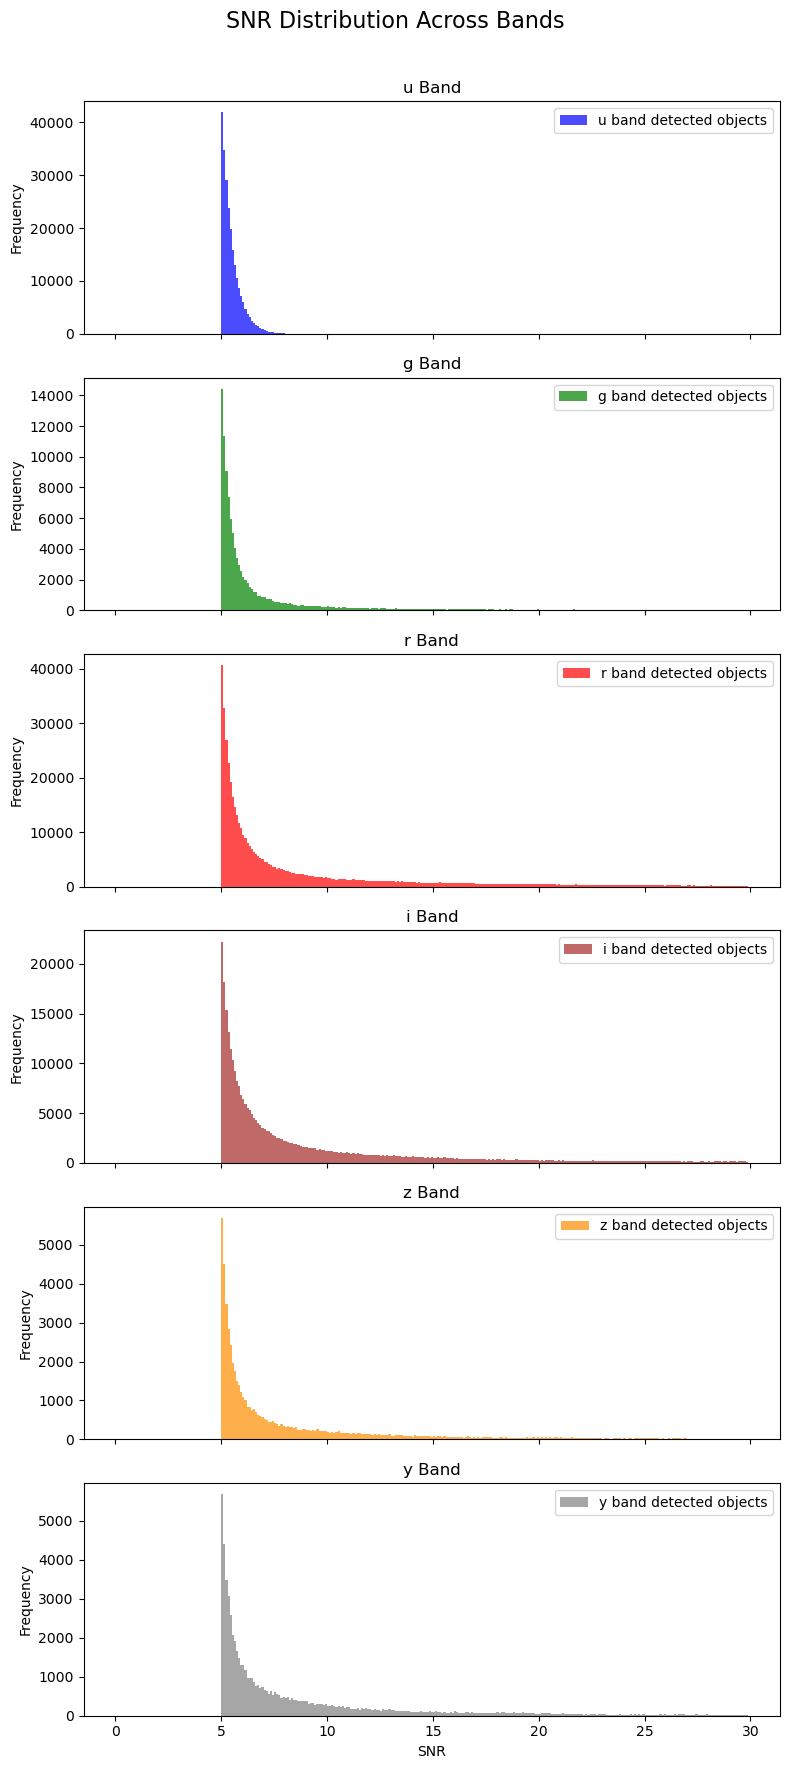

In [180]:

# Define colors for each band
band_colors = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'brown',
    'z': 'darkorange',
    'y': 'gray'
}

# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create subplots with one figure per band
fig, axes = plt.subplots(len(bands), 1, figsize=(8, 18), sharex=True)
fig.suptitle('SNR Distribution Across Bands', fontsize=16)

for ax, band in zip(axes, bands):
    # Dynamically get the correct SNR column for the current band
    column_name = f'{band}_band_snr_mean'
    snr_values = result[column_name][~np.isnan(result[column_name])]
    
    # Plot the histogram for the current band
    ax.hist(
        snr_values, 
        color=band_colors[band], 
        alpha=0.7, 
        bins=np.arange(0, 30, 0.1), 
        label=f'{band} band detected objects'
    )
    ax.set_ylabel('Frequency')
    ax.set_title(f'{band} Band')
    ax.legend()

# Set common x-axis label
axes[-1].set_xlabel('SNR')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the suptitle
plt.show()

In [ ]:
plt.hist(dia_Obj_field_updated['r_band_mag'][~np.isnan(dia_Obj_field_updated['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');


,ra,dec,nDiaSources,radecMjdTai,g_psfFluxLinearSlope,g_psfFluxLinearIntercept,g_psfFluxMAD,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,...,y_psfFluxPercentile05,y_psfFluxPercentile25,y_psfFluxPercentile50,y_psfFluxPercentile75,y_psfFluxPercentile95,y_psfFluxSigma,y_scienceFluxSigma,y_psfFluxSkew,y_psfFluxChi2,y_psfFluxStetsonJ
diaObjectId,,,,,,,,,,,,,,,,,,,,,
2430382492268625921,95.505391,-25.224280,1,60634.328488,NaN,NaN,NaN,NaN,NaN,NaN,...,-15637.508183,-15637.508183,-15637.508183,-15637.508183,-15637.508183,NaN,NaN,NaN,0.000000e+00,NaN
2430382492268625922,95.516505,-25.217411,2,60641.219499,NaN,NaN,NaN,NaN,NaN,NaN,...,-21057.774073,-21057.774073,-21057.774073,-21057.774073,-21057.774073,NaN,NaN,NaN,0.000000e+00,NaN
2430382492268625923,95.512656,-25.221502,1,60634.328488,NaN,NaN,NaN,NaN,NaN,NaN,...,-28674.863781,-28674.863781,-28674.863781,-28674.863781,-28674.863781,NaN,NaN,NaN,1.335812e-30,NaN
2430382492268625924,95.497516,-25.216558,5,60641.214104,-507086.423033,3.075034e+10,446.834704,-249531.510751,349.311672,2417.469318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430382492268625925,95.497339,-25.222527,1,60634.332367,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430619986780226346,94.763380,-24.532024,1,60641.220116,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430619986780226347,94.763274,-24.533838,1,60641.220116,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430619986780226348,94.921134,-24.527149,1,60641.221447,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
diaSource.columns

Index(['visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'extendedness',
       'reliability', 'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 

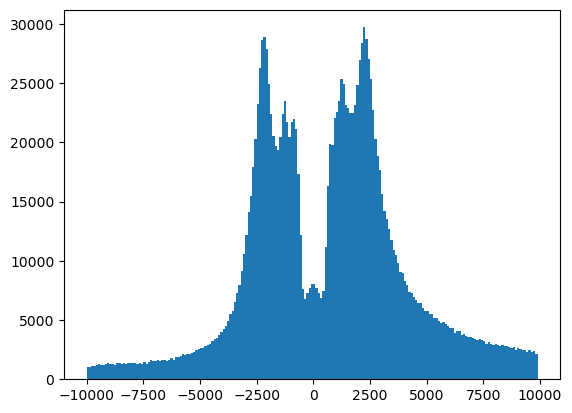

In [205]:
plt.hist(diaSource['psfFlux'],bins=np.arange(-10000,10000,100));

In [211]:
np.sum(diaSource[diaSource['psfFlux']<0]['shape_flag'])/len(diaSource[diaSource['psfFlux']<0]['shape_flag'])

0.8325305632093318

In [217]:
single_obj = dia_Obj[dia_Obj['nDiaSources'] > 10].iloc[230]
single_obj

ra                         58.634976
dec                       -49.108668
nDiaSources                16.000000
radecMjdTai             60641.110204
g_psfFluxLinearSlope             NaN
                            ...     
u_psfFluxSigma                   NaN
u_scienceFluxSigma               NaN
u_psfFluxSkew                    NaN
u_psfFluxChi2                    NaN
u_psfFluxStetsonJ                NaN
Name: 1052923121083875358, Length: 136, dtype: float64